In [2]:
!rm -Rf ~/.cache/rootpy pax_*

import os, sys
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
import pandas as pd
from scipy.optimize import curve_fit, minimize

pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/home/zhut/data/Delayed/modules')

from importlib import reload
import argparse as ap
from tqdm import tqdm

In [3]:
def plt_config(title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, colorbar = False, sci = True):
    if sci:
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.title(title)
    plt.xlim(xbounds)
    plt.ylim(ybounds)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if isinstance(colorbar,str):
        plt.colorbar(label = colorbar)
    elif colorbar:
        plt.colorbar(label = 'Number of entries')
    else:
        pass

In [4]:
pax_version = '6.6.5'
dsets = pd.read_pickle('/home/zhut/data/Delayed/data/run_names_v6.6.5_100.pkl')

In [10]:
pkl_folder_path = '/home/zhut/data/Delayed/data/pickles/pax_v6.6.5_peak_combine/'
npz_folder_path = '/home/zhut/data/Delayed/data/npzs/pax_v6.6.5_peak_combine/'

dfe_, dfp_, dfe_copy, dfp_copy, t_cover = [], [], [], [], []

for file in os.listdir(pkl_folder_path)[:]:
    if ('.pkl' in file):
        
        pkl_file_path = os.path.join(pkl_folder_path, file)
        npz_file_path = os.path.join(npz_folder_path, file[:-3] + 'npz')
        
        dfe_copy.append(pd.read_pickle(pkl_file_path))
        t_cover.append(np.load(npz_file_path)['arr_0'])
        
dfe_copy = pd.concat(dfe_copy)
t_cover = np.concatenate(t_cover)

In [14]:
op = {'bins' : (np.linspace(10.0e3,100.0e3,101), np.linspace(3.5,4.5,50))}

ndarr_weight_0 = Histdd([], [], **op).histogram


for st, en, amp in (t_cover[:]):
    ran = np.linspace(st,en-1e4,int((en-st)/1e4))
    ndarr_weight_0 += Histdd(ran/1e3, np.ones(len(ran))*np.log10(amp), **op).histogram

ndarr_weight_0 *= 10

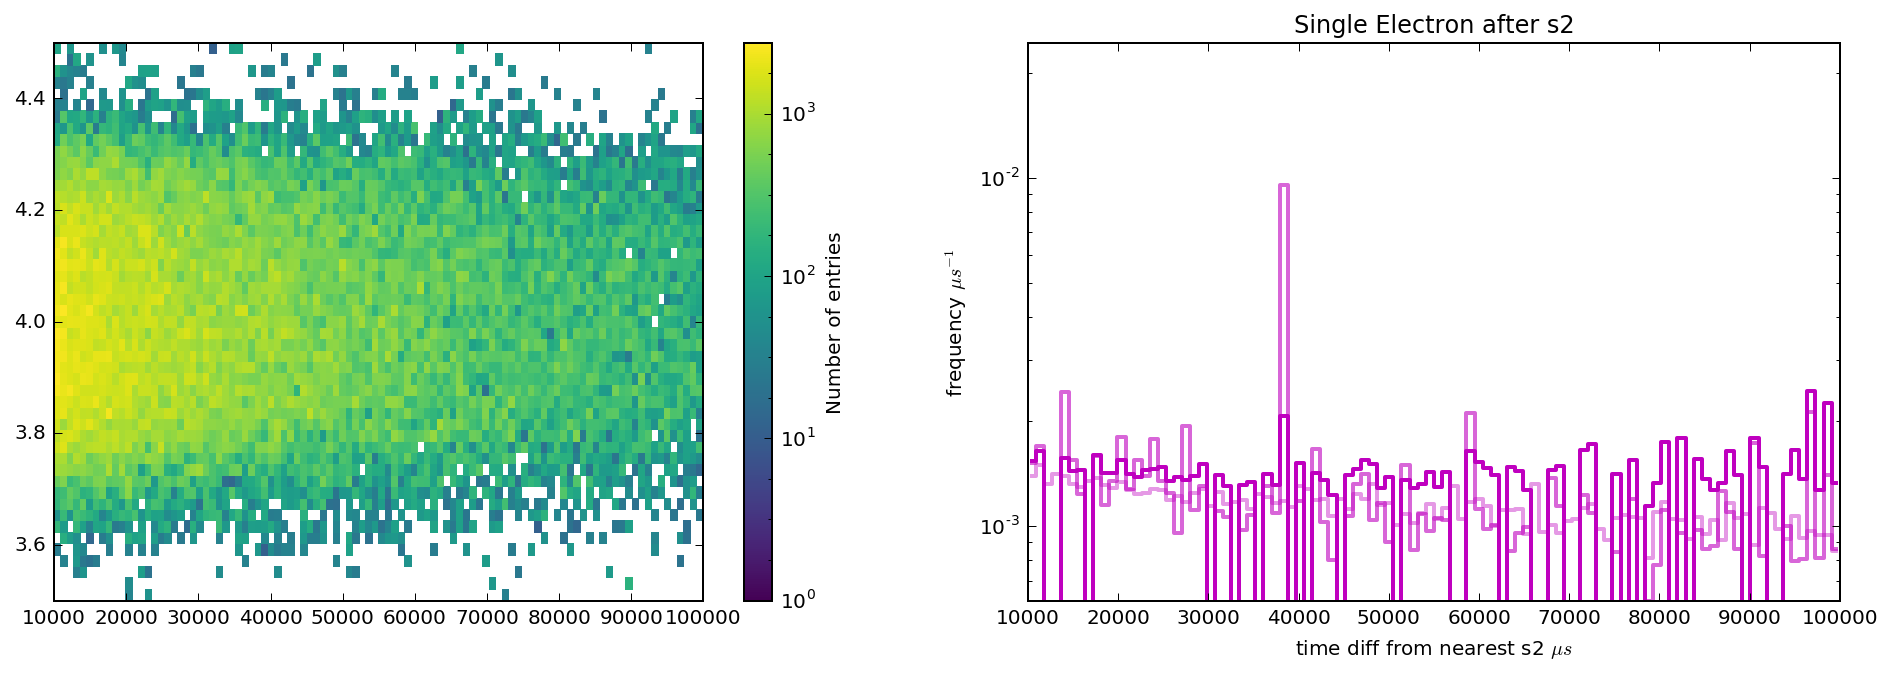

In [30]:
plt.rcParams['figure.figsize'] = (16, 5)
fig = plt.figure()

fac = 0.25
bg = 0.0

#sel_single_e = lambda df:df[(df.range_50p_area>63) & (df.range_50p_area<630) & (df.area>10) & (df.area<90)]

ax = fig.add_subplot(121)

mh = Histdd(dfe_copy.time_diff_ns2/1e3, np.log10(dfe_copy.ns2), dfe_copy.area,
            axis_names = ('time diff from nearest s2 $ns$','nearest s2 area $pe$','area$pe$'),
            bins = (np.linspace(10.0e3,100.0e3,101),
                    np.linspace(3.5,4.5,50),
                    np.linspace(10,90,50)))

hist_area = np.asarray([ [mh.bin_centers(axis = 2) for i in range(mh.histogram.shape[1])]
                          for j in range(mh.histogram.shape[0])])

mh_sum = Histdd.from_histogram(mh[:] * hist_area, 
                               bin_edges = mh.bin_edges).sum(axis = 2)

mh_sum.plot(log_scale = True, cmap=plt.get_cmap('viridis'),alpha=1.0)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Weight by ns2
ax = fig.add_subplot(122)

mh_weight_A = Histdd.from_histogram(np.asarray([10 ** (mh_sum.bin_centers(axis = 1) * fac)
                                                    for i in range(mh_sum.histogram.shape[0])]),
                                    bin_edges = mh_sum.bin_edges
                                   )

ph = Histdd.from_histogram(mh_sum[:] / mh_weight_A[:], 
                           bin_edges = mh_sum.bin_edges).project(axis = 0) # A

#ph.plot(lw = 2.0, color = 'm', ls = '--',alpha = 0.2)
ax.set_yscale("log", nonposy='clip')

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Weight also by time window frequency
#axt = ax.twinx()

ndarr_weight_B = ndarr_weight_0
mh_weight_B = Histdd.from_histogram(ndarr_weight_0, bin_edges = mh_sum.bin_edges) # B

mh_weight_AB = Histdd.from_histogram(mh_weight_A[:] * mh_weight_B[:], 
                                     bin_edges = mh_sum.bin_edges) # A * B

ph = Hist1d.from_histogram((mh_sum.project(axis = 0)[:]-mh_weight_B.project(axis = 0)*bg/np.median(mh_weight_A))
                           /mh_weight_AB.project(axis = 0)[:] + bg/np.median(mh_weight_A),
                           mh_sum.project(axis = 0).bin_edges)

ph.plot(lw = 2.0, color = 'm', ls = '-',alpha = 0.4)
#axt.set_yscale("log", nonposy='clip')

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Average over all area
# Avoid 0:
temp = mh_weight_AB[:]
temp[temp == 0] = -1

mh_weighted_p = Histdd.from_histogram((mh_sum[:] - bg/np.median(mh_weight_A[:])*mh_weight_B[:]) / temp + bg/np.median(mh_weight_A[:]),
                                      bin_edges = mh_sum.bin_edges)

ph = mh_weighted_p.sum(axis = 1)

ph = Hist1d.from_histogram(ph[:]/mh.histogram.shape[1],
                           bin_edges = ph.bin_edges)

ph.plot(lw = 2.0, color = 'm', ls = '-',alpha = 0.6)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Weighted average over all area

inv_sqr_p_hist = np.square(mh_weighted_p[:]) # To avoid * over 0
inv_sqr_p_hist[inv_sqr_p_hist == 0] = -1
inv_sqr_p_hist = 1/inv_sqr_p_hist
inv_sqr_p_hist[inv_sqr_p_hist <= 0] = 0

tmp = np.asarray([np.ones(mh.histogram.shape[1]) * x for x in mh.sum(axis = 2).sum(axis = 1)[:]])

mh_weight_chi2 = Histdd.from_histogram(mh.sum(axis = 2)[:] /tmp,
                                       bin_edges = mh_sum.bin_edges)

mh_sig_weighted_p = Histdd.from_histogram(mh_weighted_p[:] * mh.sum(axis = 2)[:] / tmp,
                                          bin_edges = mh_sum.bin_edges)

ph = mh_sig_weighted_p.sum(axis = 1)
ph.plot(lw = 2.0, color = 'm', ls = '-',alpha = 1.0)

if False:"""
def func(x,a,t):
    return a/t*np.exp(-x/t) + bg/np.median(mh_weight_A[:])
result = curve_fit(func,ph.bin_centers[20:90],ph[20:90],p0 = [50,5e3])
x = ph.bin_centers
plt.plot(x, func(x,*result[0]), 'r--')"""

#plt.axhline(bg/np.median(mh_weight_A[:]), color = 'r', ls = '--', lw = 1.0)

plt_config(title = 'Single Electron after s2', 
           xbounds = [10e3,100e3],
           ybounds = [np.amin(ph[:])/10,np.amax(ph[:])*10],
           xlabel = 'time diff from nearest s2 $\mu s$', 
           ylabel = 'frequency $\mu s ^{-1}$', 
           colorbar = False, sci = False)
plt.show()

#print (result[0])

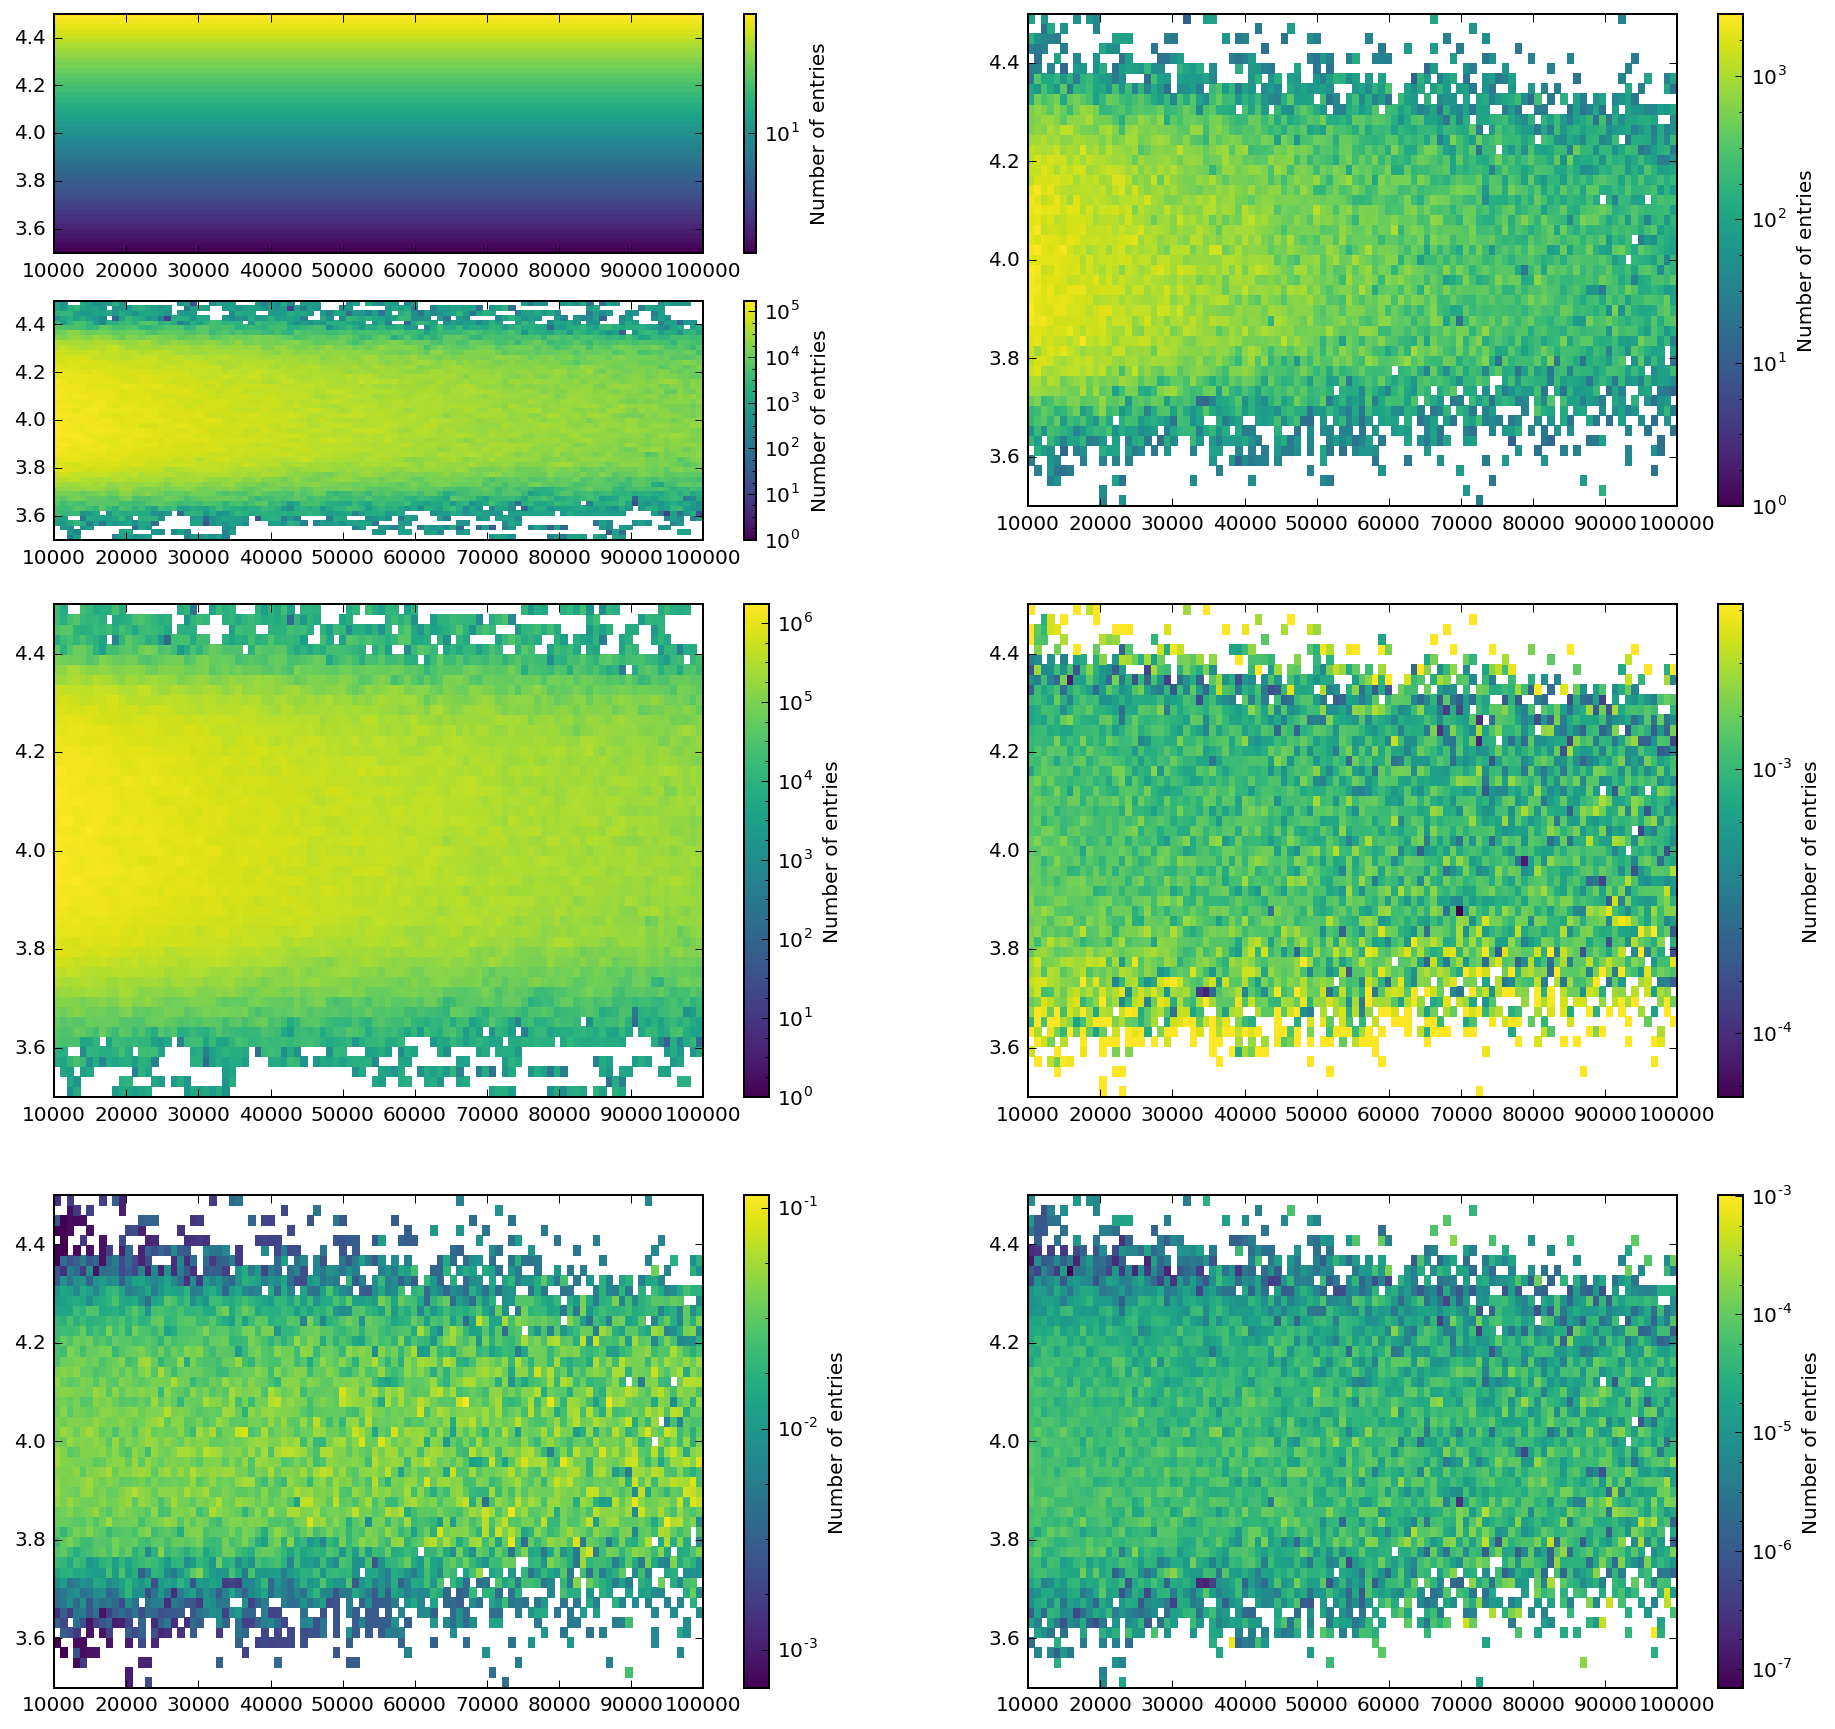

In [34]:
plt.rcParams['figure.figsize'] = (16, 15)
fig = plt.figure()

ax = fig.add_subplot(621)
mh_weight_A.plot(log_scale = True, cmap=plt.get_cmap('viridis'),alpha=1.0)

ax = fig.add_subplot(623)
mh_weight_B.plot(log_scale = True, cmap=plt.get_cmap('viridis'),alpha=1.0)

ax = fig.add_subplot(322)
mh_sum.plot(log_scale = True, cmap=plt.get_cmap('viridis'),alpha=1.0)

ax = fig.add_subplot(323)
mh_weight_AB.plot(log_scale = True, cmap=plt.get_cmap('viridis'),alpha=1.0)

ax = fig.add_subplot(324)
mh_weighted_p.plot(log_scale = True, cmap=plt.get_cmap('viridis'),
                   norm=LogNorm(vmax=np.amax(mh_weighted_p[:])/100) ,alpha=1.0)

ax = fig.add_subplot(325)
mh_weight_chi2.plot(log_scale = True, cmap=plt.get_cmap('viridis'),
                    norm=LogNorm(vmax=np.amax(mh_weight_chi2[:])) ,alpha=1.0)

ax = fig.add_subplot(326)
mh_sig_weighted_p.plot(log_scale = True, cmap=plt.get_cmap('viridis'),
                       norm=LogNorm(vmax=np.amax(mh_sig_weighted_p[:])) ,alpha=1.0)

plt.show()